# Modelos de Difusão com o CIFAR10

Neste exercício prático iremos mostrar como funciona um simples procedimento de difusão por redução de ruído. Os modelos de difusão de redução de ruído, surgiram recentemente como uma poderosa classe de modelos generativos. Eles demonstram resultados surpreendentes na geração de imagens de alta fidelidade, muitas vezes até superando as redes adversárias generativas.

Os modelos de difusão de redução de ruído definem um processo de difusão direta que mapeia dados para ruído perturbando gradualmente os dados de entrada. A geração de dados é obtida usando um processo reverso parametrizado e aprendido que executa a redução de ruído iterativa, começando com ruído aleatório puro.

In [1]:
import os
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

## Montando o conjunto de dados

Iremos utilizar o conjunto do CIFAR10 para realizar um exemplo minimalista de como funciona o processo de difusão por redução de ruído. Sendo assim, para deixar o treinamento mais rápido e mais estável, selecionaremos apenas imagens de carros (classe 1) do CIFAR10. Logo em seguida, iremos normalizar os dados de entrada entre [-1, 1].

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train[y_train.squeeze() == 1]
X_train = (X_train / 127.5) - 1.0

170498071/170498071 [==============================] - 4s 0us/step


## Modelos de Difusão por redução de ruído

- Difusão direta: adiciona ruído gradualmente ao dado de entrada
- Difusão reverssa (processo generativo): modelo aprende a gerar o dado a partir do dado ruidoso

![](https://cvpr2022-tutorial-diffusion-models.github.io/img/diffusion.png)

In [3]:
IMG_SIZE = 32     # tamanho da imagem de entrada, CIFAR-10 possui 32x32
BATCH_SIZE = 128  # tamanho do batch para treinar o modelo
timesteps = 16    # quantos passos (timesteps) serão realizados até a imagem ruidosa ao final
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # Intensidade dos timesteps

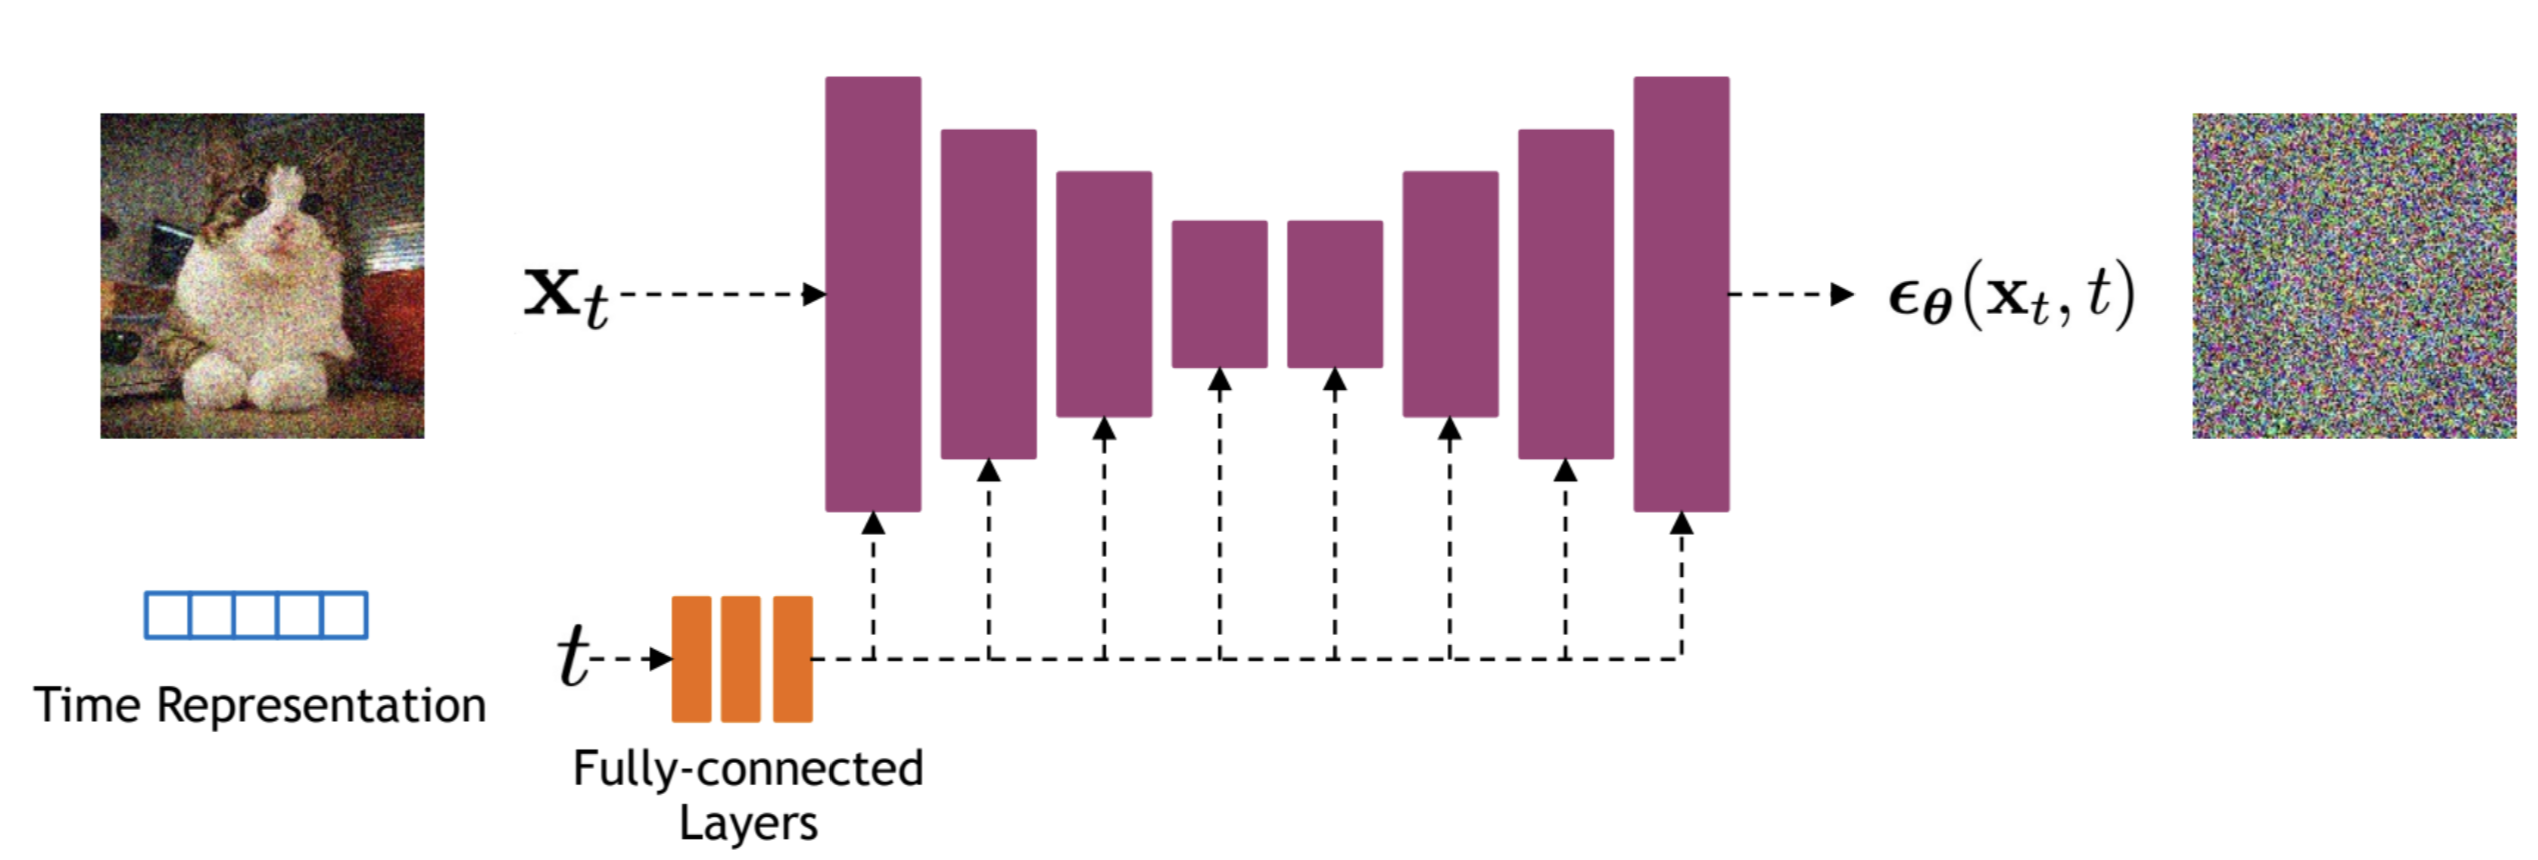

### Funções auxiliares para visualizar o conjunto de dados

In [4]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

## Exemplos após a aplicação do ruído

Aqui, precisamos do código para preparar as imagens de treinamento.
A ideia é obter duas imagens (A e B) de pontos de tempo distintos, onde A é uma imagem com ruído e B é uma imagem muito menos ruidosa obtida a partir do processo generativo da rede.
Nosso modelo aprenderá a transformar A em B (de ruidoso para menos ruidoso) com base nesse ponto de tempo específico.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*KkxAfGzDNOpOQfPcEn-ldw.png)

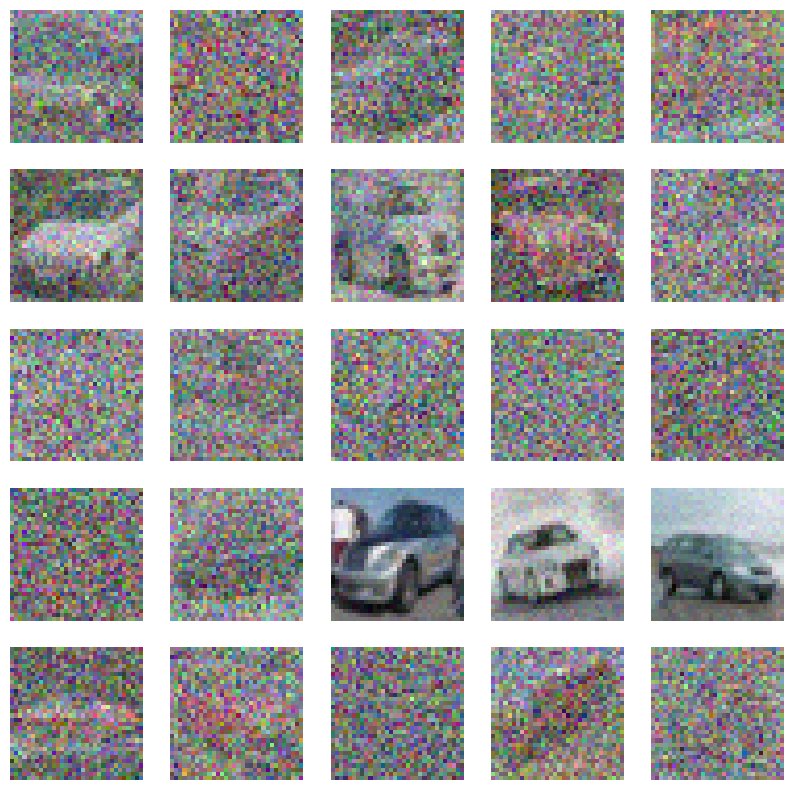

In [5]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1)
# t = np.full((25,), 0)
t = generate_ts(25)   # gera timesteps aleatorios
a, b = forward_noise(X_train[:25], t)
show_examples(a)

## Modelo U-Net

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*jhqgZSzDeZx9YMR9QndmsQ.png)

In [6]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

In [7]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model


model = make_model()

## Escolhendo Otimizador e função de custo

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

## Função para inferência

Nesta primeira etapa, iremos realizar inferências a partir de um ruído aleatório apenas para entendermos como o modelo funciona.

Agora podemos tentar nossa primeira previsão. Os passos para a previsão são os seguintes:
- criar imagens ruidosas
- entrada para o nosso modelo com passo de tempo
- continuar fazendo isso até o final de todos os timesteps

  0%|          | 0/16 [00:00<?, ?it/s]

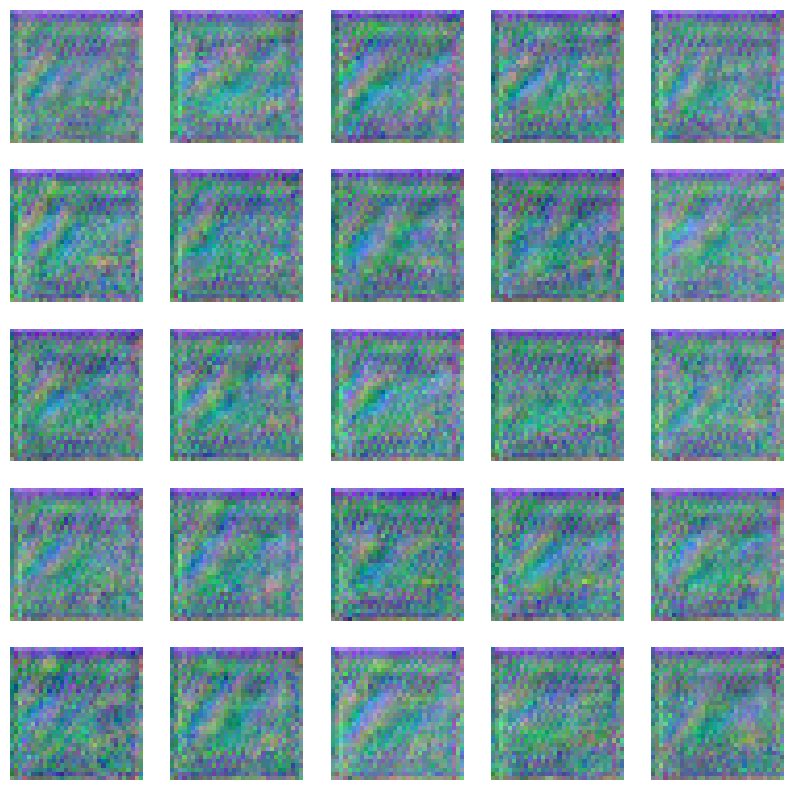

In [9]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

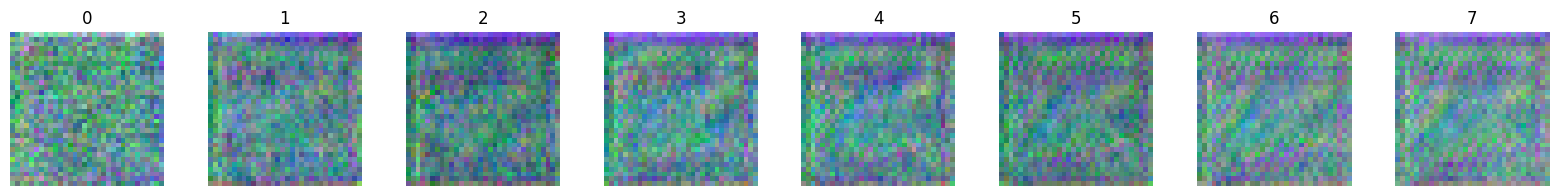

In [10]:
def predict_step():
    xs = []
    # gera um ruído aleatório
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    # passa por todos os timesteps
    for i in trange(timesteps):
        # para aquele timestep, realiza a predição para aquele nivel de ruido
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

## Processo de treinamento do modelo

In [11]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [12]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

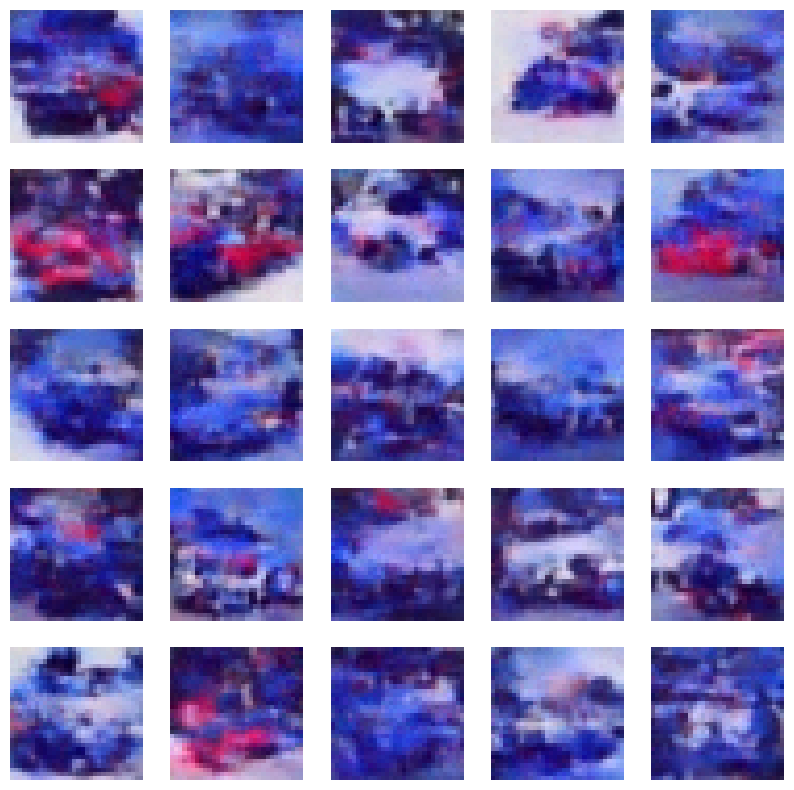

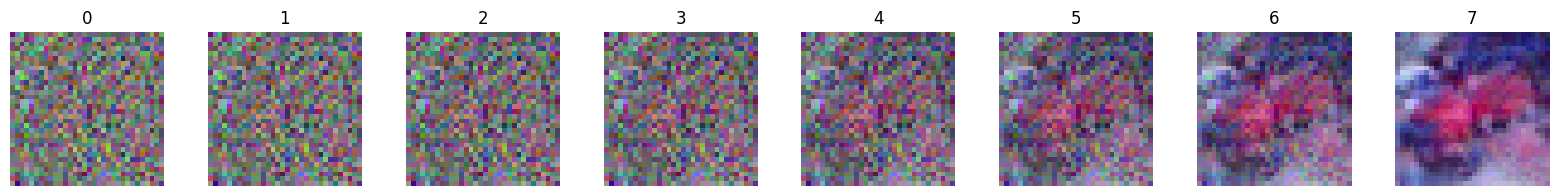

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

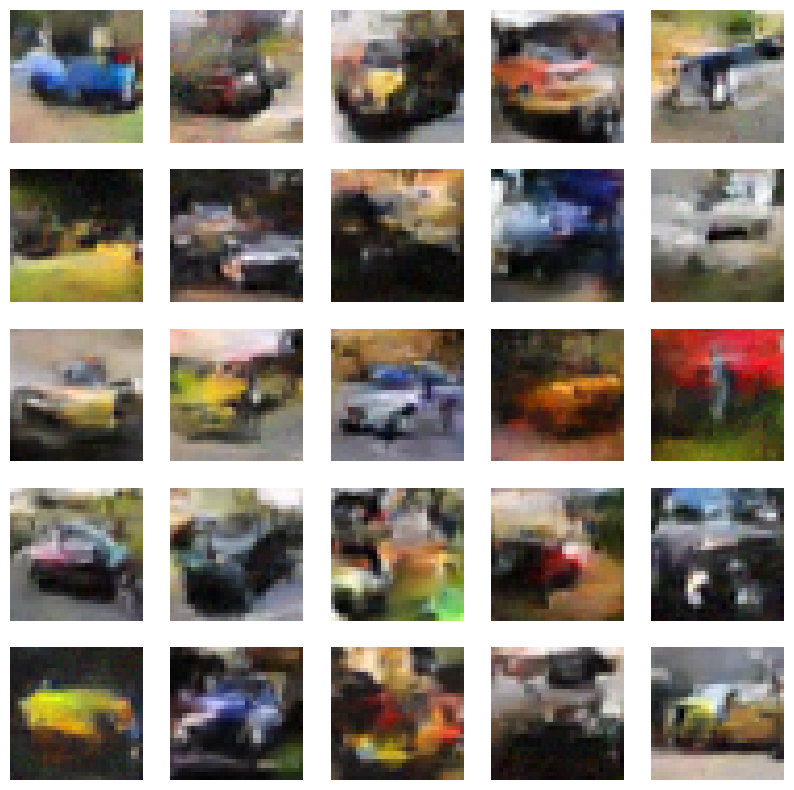

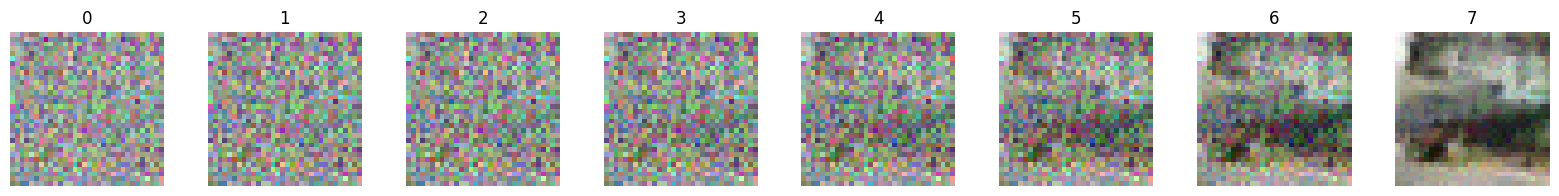

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

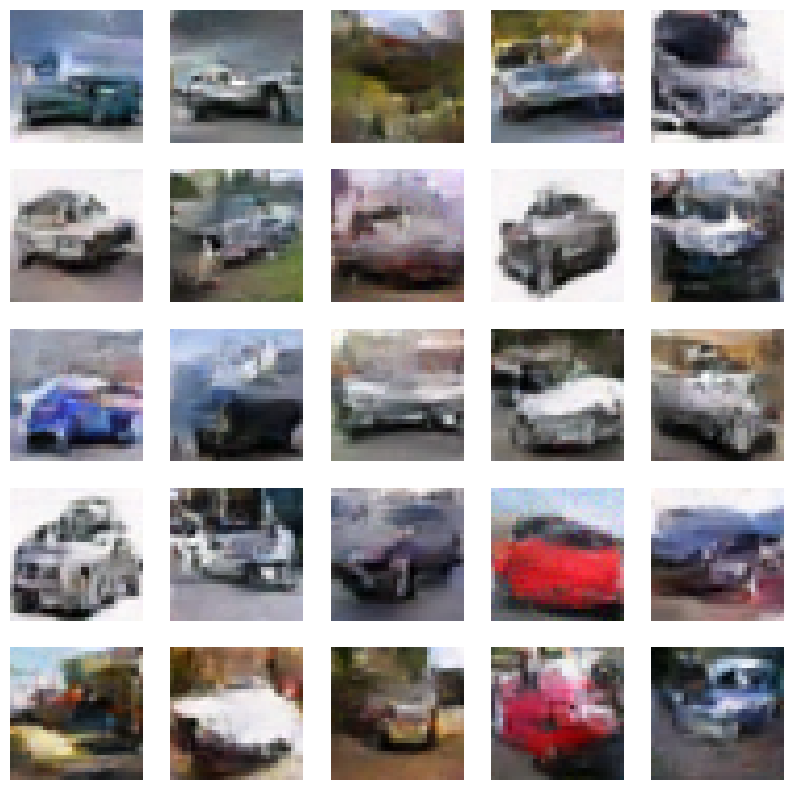

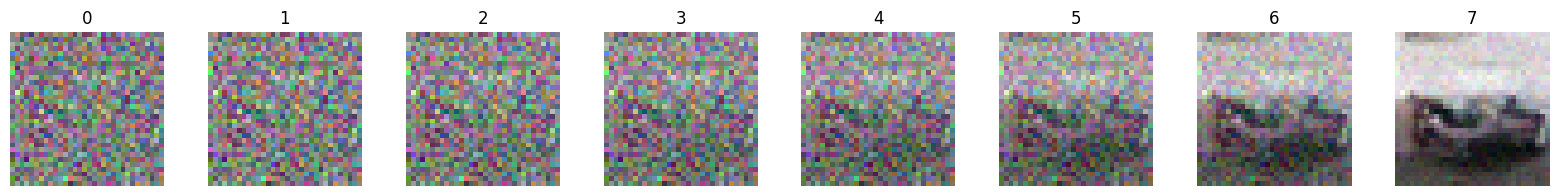

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

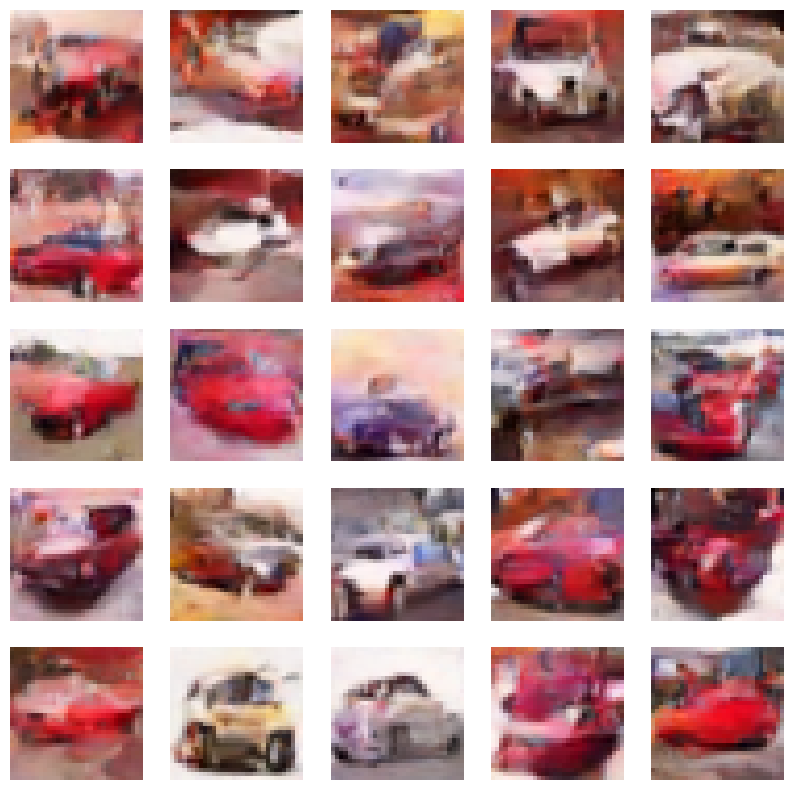

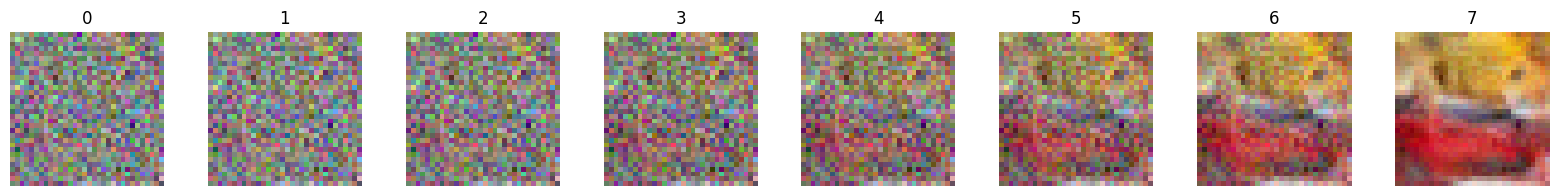

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

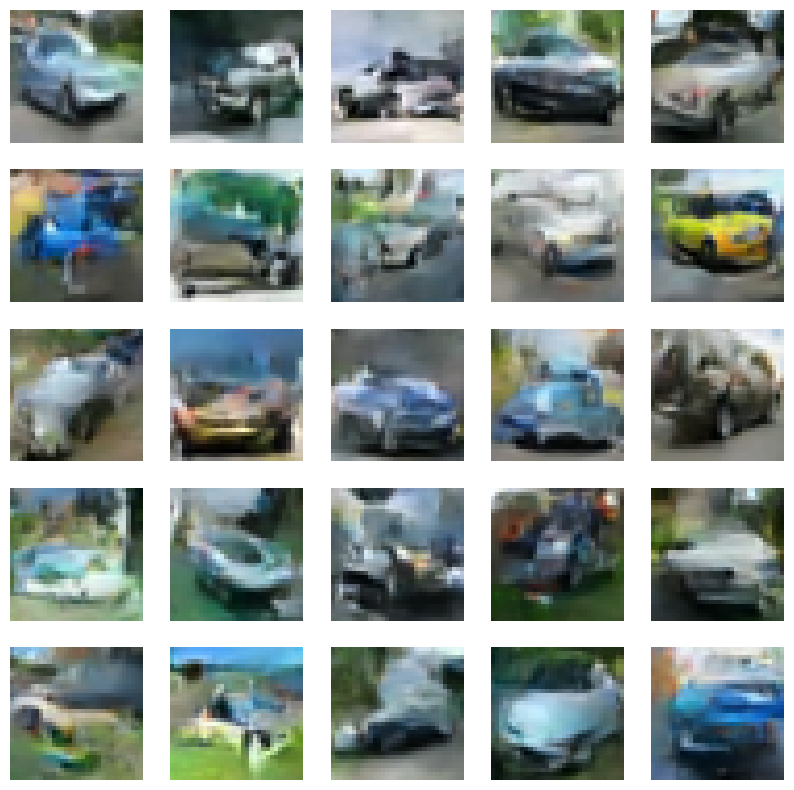

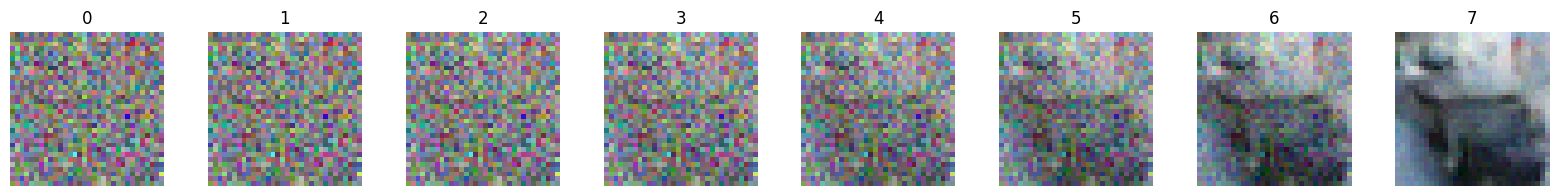

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

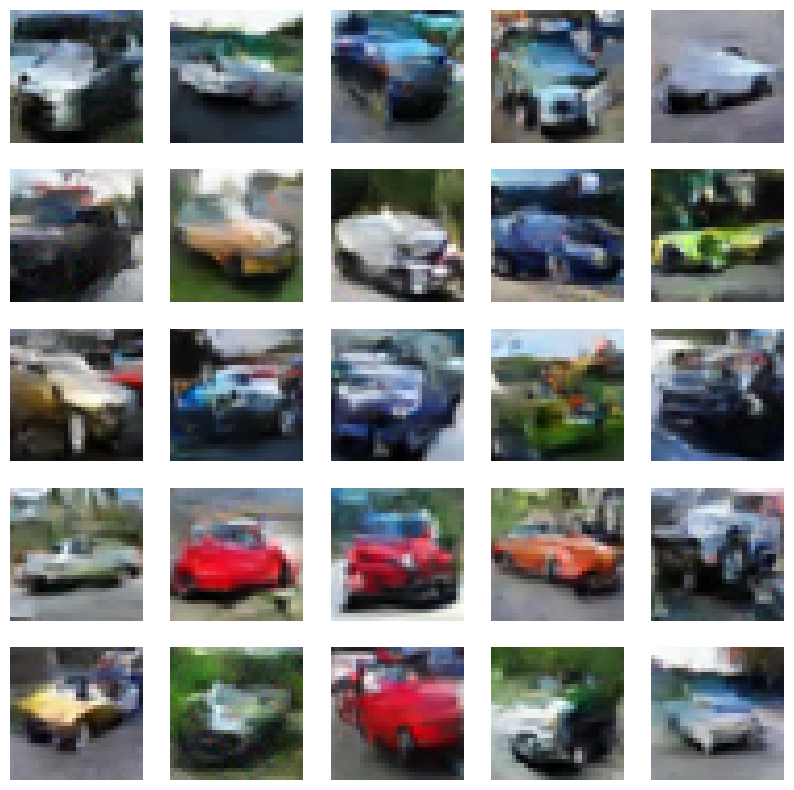

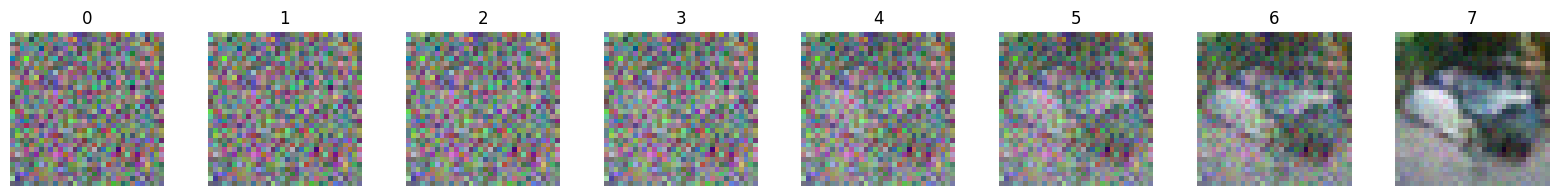

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

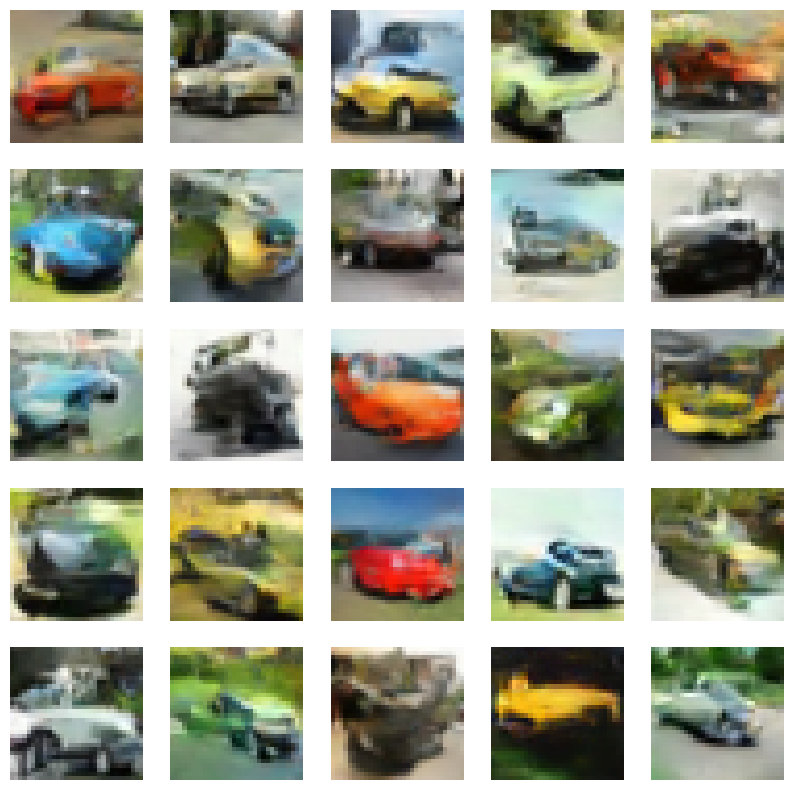

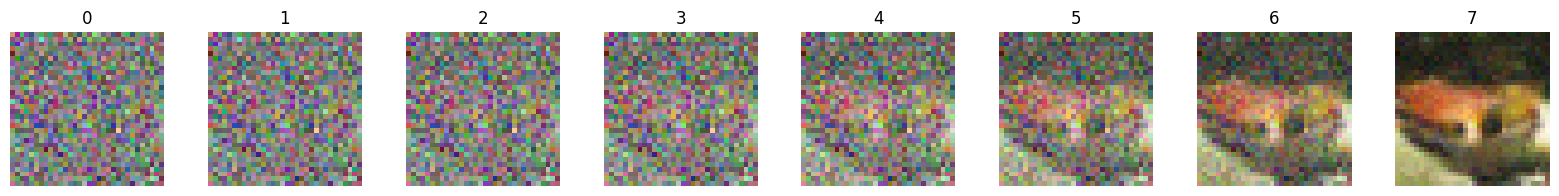

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

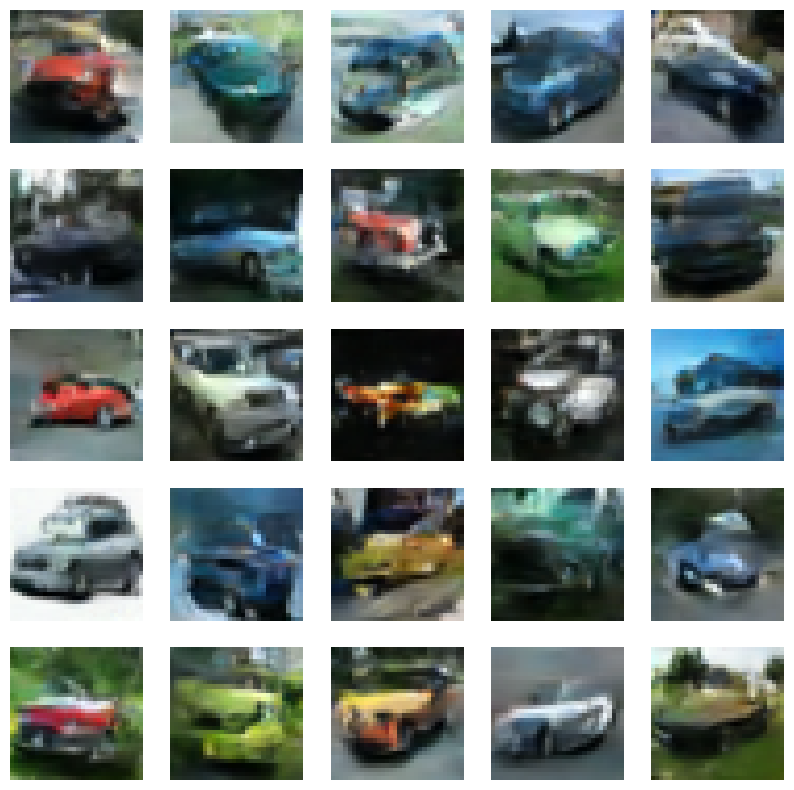

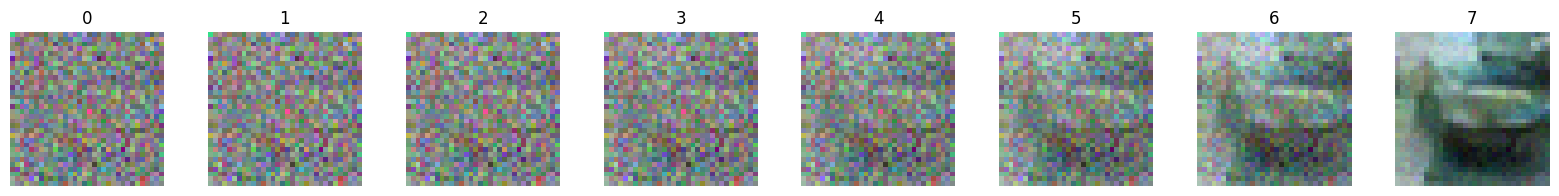

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

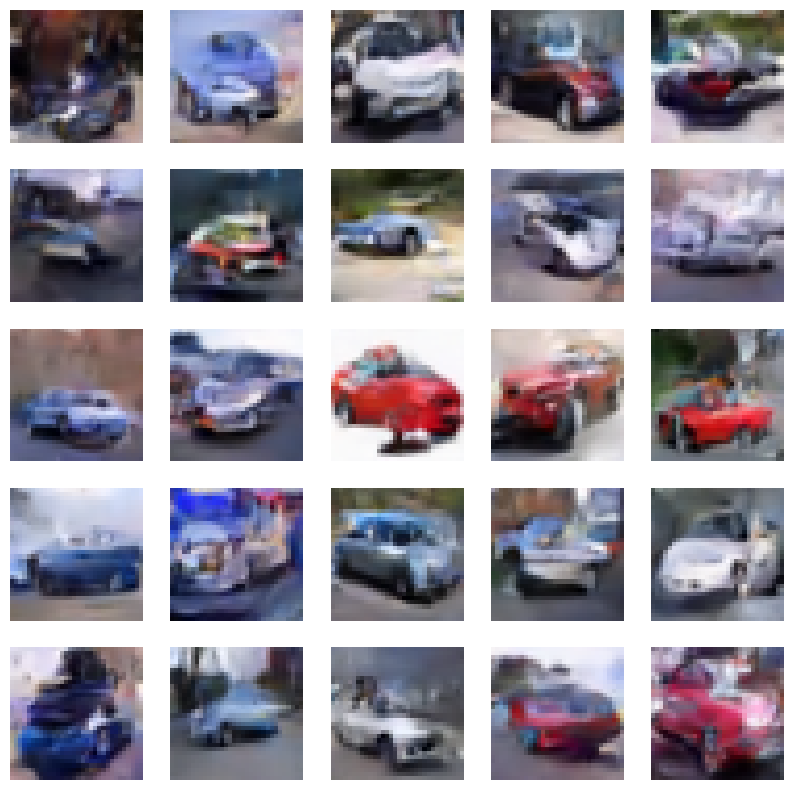

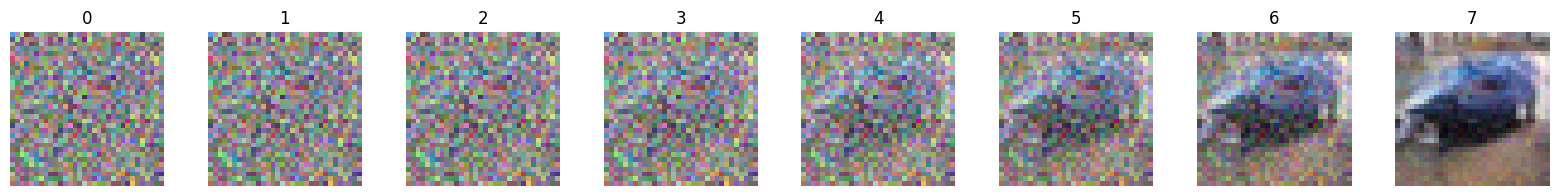

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

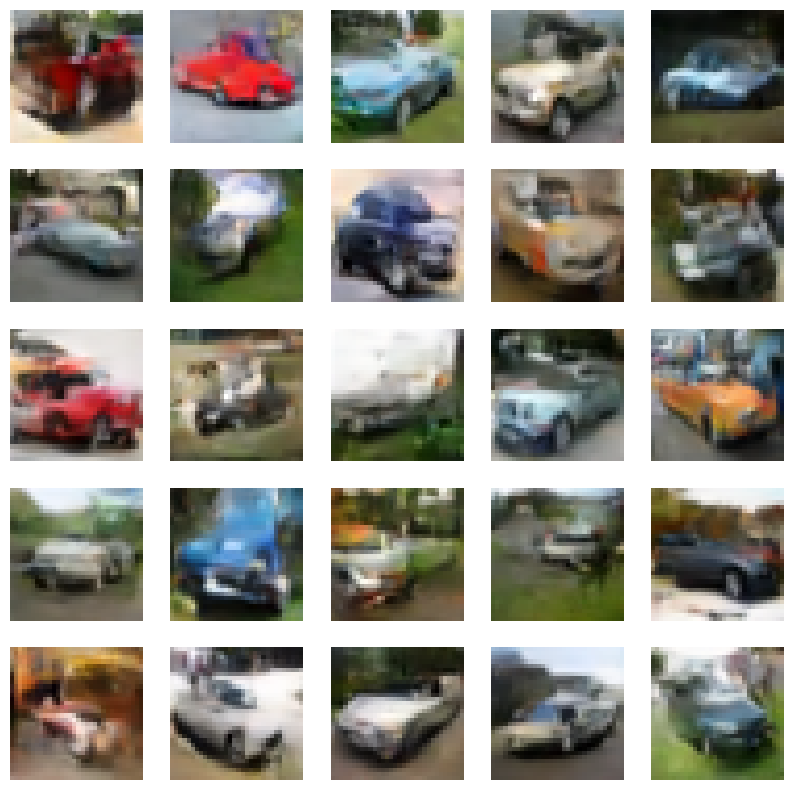

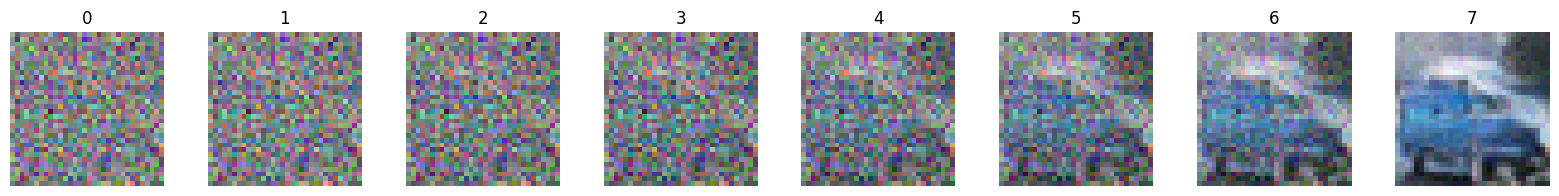

In [13]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()

![](https://miro.medium.com/v2/resize:fit:1216/1*ESCM1HCpPuFwL0OBe8qbqw.gif)